In [46]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict

import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

In [2]:
test_df = pd.read_csv('../data/test.csv')

In [3]:
train_df = pd.read_csv('../data/train.csv')

In [4]:
test_df.rename(mapper=lambda x: x.lower().replace(' ', '_'), axis='columns', inplace=True)

In [5]:
test_df.set_index('id', inplace=True)

# Eliminate NaN's:
I consulted a data dictionary and found several variables with NaN (Not a Number) in the dataset were truly missing these items (e.g., had no pool, or had no garage, etc.). I filled these data with na. See below for specific commentary where needed.

In [6]:
test_df.drop(columns='pid', inplace=True)

In [7]:
def find_NaNs_left_to_clean(df=train_df):
    return df.loc[:, df.isnull().sum() != 0].isnull().sum()

In [8]:
find_NaNs_left_to_clean(train_df)

Lot Frontage       330
Alley             1911
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           55
Bsmt Cond           55
Bsmt Exposure       58
BsmtFin Type 1      55
BsmtFin SF 1         1
BsmtFin Type 2      56
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Pool QC           2042
Fence             1651
Misc Feature      1986
dtype: int64

In [9]:
test_df['pool_qc'].fillna('na', inplace=True)

In [10]:
test_df['misc_feature'].fillna('na', inplace=True)

In [11]:
test_df['lot_frontage'].fillna('0', inplace=True)

There appears to be some properties whose boundaries do not border streets (see map, https://ww2.amstat.org/publications/jse/v19n3/decock/AmesResidential.pdf). Therefore, I decided that some properties truly had no lot_frontage. Discovery happened during discussion with a colleague, Bing Chen; see also his presentation.

In [12]:
test_df['alley'].fillna('none', inplace=True)

In [13]:
test_df['pool_qc'].fillna('na', inplace=True)

In [14]:
test_df['fence'].fillna('none', inplace=True)

In [15]:
test_df['misc_feature'].fillna('none', inplace=True)

In [16]:
test_df['mas_vnr_type'].fillna('None', inplace=True)  # Justification:  modal value

In [17]:
test_df['mas_vnr_area'].fillna('0', inplace=True)  # Justfication:  consistency with mas_vnr_type

In [18]:
test_df['bsmt_qual'].fillna('no_basement', inplace=True)

In [19]:
test_df['bsmt_cond'].fillna('no_basement', inplace=True)

In [20]:
test_df['bsmt_exposure'].fillna('no_basement', inplace=True)

In [21]:
test_df['bsmtfin_type_1'].fillna('no_basement', inplace=True)

In [22]:
test_df['bsmtfin_type_2'].fillna('no_basement', inplace=True)

In [23]:
test_df['bsmtfin_sf_2'].fillna('0', inplace=True)

In [24]:
test_df['bsmt_unf_sf'].fillna('0', inplace=True)

In [25]:
test_df['total_bsmt_sf'].fillna('0', inplace=True)

In [26]:
test_df['bsmtfin_sf_1'].fillna('0', inplace=True)

In [27]:
test_df['bsmt_full_bath'].fillna('0', inplace=True)

In [28]:
test_df['bsmt_half_bath'].fillna('0', inplace=True)

In [29]:
test_df['fireplace_qu'].fillna('no_fireplace', inplace=True)

Adding up all houses with 1 or more fireplaces, you get a the same as the number of houses with fireplace_quality ratings. All houses with NA for fireplace_quality have zero fireplaces.

In [30]:
test_df['garage_type'].fillna('no_garage', inplace=True)

In [31]:
test_df['garage_yr_blt'].fillna('0', inplace=True)

All houses that are NaN for garage_yr_blt do not have garages. Coding these as '0' loses what ordinality there might be to this variable, but since I plan on turning this variable into a categorical variable it does not matter in this analysis.

In [32]:
test_df['garage_finish'].fillna('no_garage', inplace=True)

In [33]:
test_df['garage_cars'].fillna('0', inplace=True)

In [34]:
test_df['garage_area'].fillna('0', inplace=True)

In [35]:
test_df['garage_qual'].fillna('no_garage', inplace=True)   # Mostly lined up with properties w/o garages.

In [36]:
test_df['garage_cond'].fillna('no_garage', inplace=True)   # Mostly lined up with properties w/o garages.

In [37]:
find_NaNs_left_to_clean(test_df)

electrical    1
dtype: int64

In [38]:
test_df[test_df['electrical'].isna() == True]

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type
id,,,,,,,,,,,,,,,,,,,,,
1578,80,RL,73,9735,Pave,none,Reg,Lvl,AllPub,Inside,...,0,0,0,na,none,na,0,5,2008,WD


In [39]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ms_subclass,879.0,58.270762,42.211389,20.0,20.0,50.0,70.0,190.0
lot_area,879.0,10340.920364,10047.335167,1477.0,7298.5,9453.0,11606.5,215245.0
overall_qual,879.0,6.054608,1.374756,2.0,5.0,6.0,7.0,10.0
overall_cond,879.0,5.565415,1.128422,1.0,5.0,5.0,6.0,9.0
year_built,879.0,1970.533561,30.403527,1880.0,1954.0,1972.0,2000.0,2010.0
year_remod/add,879.0,1984.444824,20.454546,1950.0,1967.0,1992.0,2003.0,2010.0
bsmtfin_sf_1,879.0,443.397042,442.480223,0.0,0.0,374.0,735.5,2288.0
bsmtfin_sf_2,879.0,53.835040,178.539854,0.0,0.0,0.0,0.0,1526.0
bsmt_unf_sf,879.0,539.518771,426.082726,0.0,216.0,453.0,781.5,2046.0
total_bsmt_sf,879.0,1036.750853,419.258428,0.0,790.0,975.0,1248.0,3138.0


#### There may be other variables that need to be eliminated, or edited for outliers. Let's begin our 
#'visual EDA':

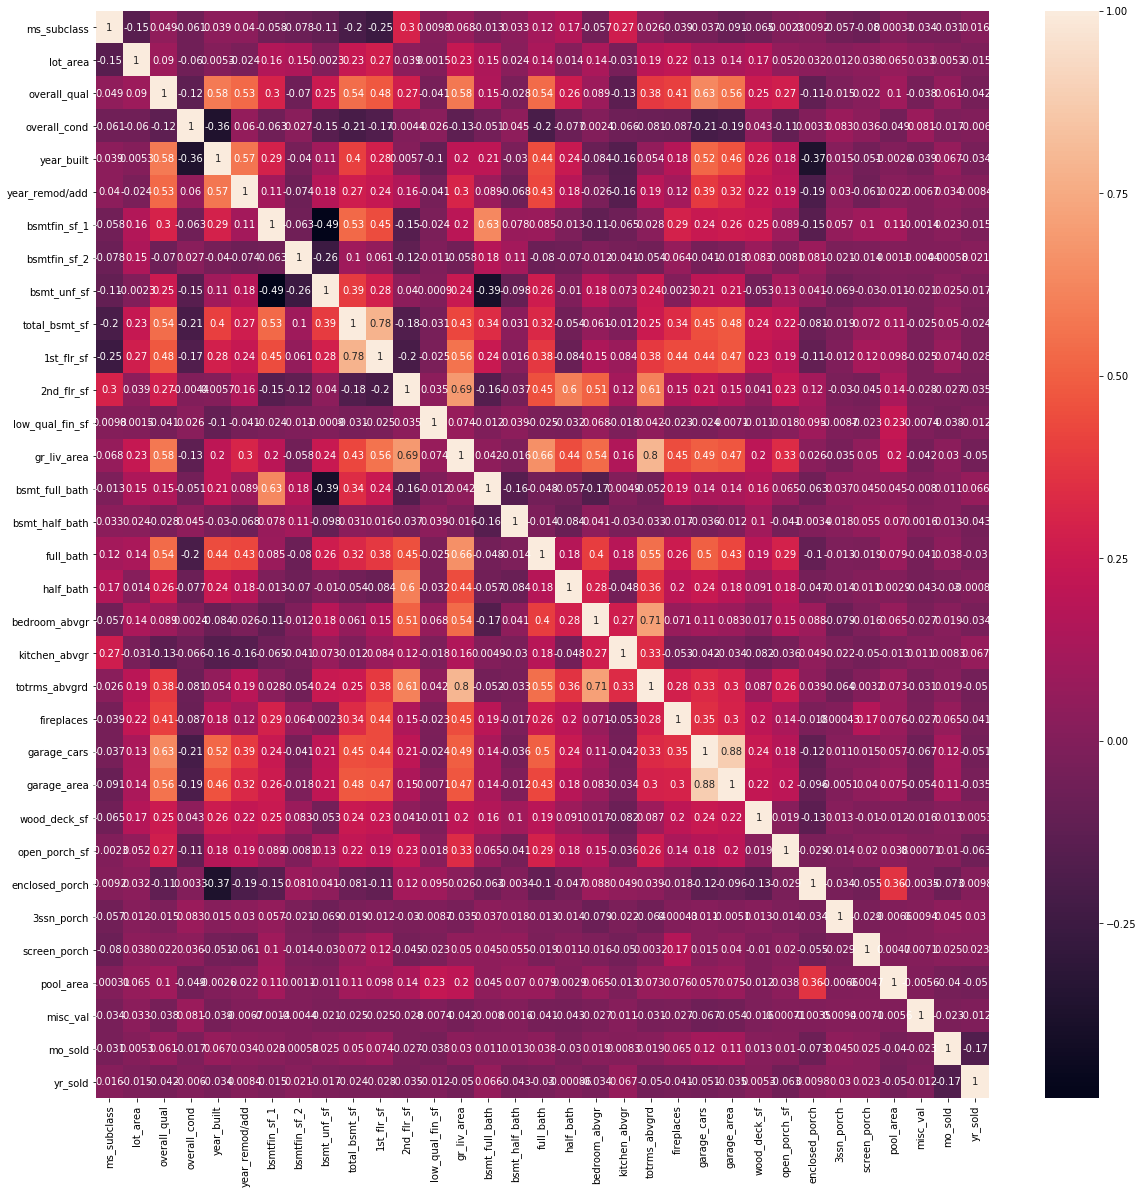

In [40]:
plt.figure(figsize=(20,20))
sns.heatmap(test_df.corr(), annot=True);

# Get Dummies:  Convert Continuous Var to Categorical, MSClass

In [41]:
test_df.ms_subclass = test_df.ms_subclass.astype('object')

In [42]:
cols_need_dummies = test_df.select_dtypes(include='object').columns

In [43]:
cols_need_dummies

Index(['ms_subclass', 'ms_zoning', 'lot_frontage', 'street', 'alley',
       'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope',
       'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'roof_style', 'roof_matl', 'exterior_1st',
       'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_type_2', 'heating', 'heating_qc',
       'central_air', 'electrical', 'kitchen_qual', 'functional',
       'fireplace_qu', 'garage_type', 'garage_yr_blt', 'garage_finish',
       'garage_qual', 'garage_cond', 'paved_drive', 'pool_qc', 'fence',
       'misc_feature', 'sale_type'],
      dtype='object')

In [45]:
test_df_dummies = pd.get_dummies(test_df, columns=cols_need_dummies)

# Standardize Variables:

In [ ]:
#y_test = test_df_dummies['saleprice']  # Find the target -- there is no target!!

In [ ]:
X_test = test_df_dummies.drop(columns='saleprice')  # Everything but the target

In [ ]:
X.dtypes

In [ ]:
pd.options.display.max_rows = 999

In [ ]:
test_df_dummies.T

In [ ]:
ss=StandardScaler()

In [ ]:
ss.transform(X_test)

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(train_df_stand.corr(), annot=True);

# Elastic Net vars

In [ ]:
ridge.

In [ ]:
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
ss=StandardScaler()